Exercise 8
===
Let's create an autoencoder network that pretrains on MNIST images.

In [1]:
%autosave 60

import tensorflow as tf
import numpy as np
from tensorflow.contrib.layers import batch_norm, dropout
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

Autosaving every 60 seconds
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [2]:
import math
from sklearn.base import BaseEstimator, ClassifierMixin
import tensorflow as tf

def he_normal_initialisation(n_inputs, n_outputs):
    stddev = np.power(2 / (n_inputs + n_outputs), 1 / np.sqrt(2))
    # truncated normal distributions limit the size of the weights, speeding up the training time.
    return tf.truncated_normal((n_inputs, n_outputs), stddev=stddev)

def he_uniform_initialisation(n_inputs, n_outputs):
    r = np.power(6 / (n_inputs + n_outputs), 1 / np.sqrt(2))
    # truncated normal distributions limit the size of the weights, speeding up the training time.
    return tf.random_uniform((n_inputs, n_outputs), -r, r)

def create_next_batch_fn(data, sequence_lengths, targets, batch_size):
    assert len(data) == len(sequence_lengths) and len(data) == len(targets)
    current_batch = 0
    def next_batch():
        nonlocal current_batch
        i = current_batch
        #print(current_batch)
        current_batch = (current_batch + batch_size) % len(data)
        return data[i:i+batch_size], sequence_lengths[i:i+batch_size], targets[i:i+batch_size]
    return next_batch

In [34]:
import math

input_spatial_size = 28
input_channels = 1
batch_size = 80

learning_rate = 0.01
n_input_neurons = input_spatial_size ** 2
n_hidden_neurons_layer1 = 250
n_hidden_neurons_layer2 = 150
n_hidden_neurons_layer3 = n_hidden_neurons_layer1
n_output_neurons = n_input_neurons
l2_reg = 0.0001

#initializer = lambda a: he_uniform_initialisation(a[0], a[1])#tf.contrib.layers.variance_scaling_initializer()
#activation = tf.nn.elu
#regularizer = tf.contrib.layers.l2_regularizer(l2_reg)

with tf.device("/gpu:0"):
    X = tf.placeholder(tf.float32, shape=(None, n_input_neurons), name="input") 
    """
    weights1 = initializer([n_input_neurons, n_hidden_neurons_layer1])
    biases1 = tf.Variable(tf.zeros(n_hidden_neurons_layer1))
    
    weights2 = initializer([n_hidden_neurons_layer1, n_hidden_neurons_layer2])
    biases2 = tf.Variable(tf.zeros(n_hidden_neurons_layer2))
    
    weights3 = initializer([n_hidden_neurons_layer2, n_hidden_neurons_layer3])
    biases3 = tf.Variable(tf.zeros(n_hidden_neurons_layer3))
    
    weights4 = initializer([n_hidden_neurons_layer3, n_output_neurons])
    biases4 = tf.Variable(tf.zeros(n_output_neurons))
    
    hidden1 = activation(tf.matmul(X, weights1) + biases1)
    hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
    hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
    outputs = tf.matmul(hidden3, weights4) + biases4
    """
    he_init = tf.contrib.layers.variance_scaling_initializer()
    l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
    from functools import partial
    my_dense_layer = partial(tf.layers.dense,
                             activation=tf.nn.elu,
                             kernel_initializer=he_init)

    hidden1 = my_dense_layer(X, n_hidden_neurons_layer1)
    hidden2 = my_dense_layer(hidden1, n_hidden_neurons_layer2)
    hidden3 = my_dense_layer(hidden2, n_hidden_neurons_layer3)
    outputs = my_dense_layer(hidden3, n_output_neurons, activation=None)

    with tf.name_scope("loss"):
        reconstruction_loss = tf.reduce_mean(tf.square(outputs - X), name="reconstruction_loss")
        #regularisation_loss = regularizer(weights1) + regularizer(weights2) \
        #    + regularizer(weights3) + regularizer(weights4)
        #regularisation_loss = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        loss = reconstruction_loss# + regularisation_loss

    with tf.name_scope("training"):
        optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
        training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

saver = tf.train.Saver()

interim_checkpoint_path = "./checkpoints/mnist_autoencoder_model.ckpt"
early_stopping_checkpoint_path = "./checkpoints/mnist_autoencoder_model_early_stopping.ckpt"

from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
log_dir = "{}/run-{}/".format(root_logdir, now)

loss_summary = tf.summary.scalar('loss', loss)
summary_op = tf.summary.merge([loss_summary])
file_writer = tf.summary.FileWriter(log_dir, tf.get_default_graph())

epochs = 20
n_batches = int(np.ceil(len(mnist.train.images) // batch_size))

early_stopping_check_frequency = n_batches // 4
early_stopping_check_limit = n_batches * 3

sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
session = sess
sess.run(init)
#saver.restore(sess, interim_checkpoint_path)

best_loss = 1000000000.0
best_loss_step = 0
for epoch in range(epochs):
    print("epoch", epoch)
    for batch_index in range(n_batches):
        step = epoch * n_batches + batch_index
        # TODO: replace this with code that gets a batch from X and y.
        X_batch, y_batch = mnist.train.next_batch(batch_size)
        if batch_index % 10 == 0:
            summary_str = summary_op.eval(session=sess, feed_dict={X: X_batch})
            file_writer.add_summary(summary_str, step)
        t = sess.run([training_op], feed_dict={X: X_batch})
        l = sess.run(reconstruction_loss, feed_dict={X: X_batch})
        if batch_index % 10 == 0: print("loss:", l)
        # Early stopping check
        if batch_index % early_stopping_check_frequency == 0:
            if l < best_loss:
                saver.save(sess, early_stopping_checkpoint_path)
                best_loss = l
                best_loss_step = step
            elif step >= (best_loss_step + early_stopping_check_limit):
                print("Stopping early during epoch", epoch, "with best loss:", best_loss)
                break
    else:
        continue
    break
    save_path = saver.save(sess, interim_checkpoint_path)
saver.restore(sess, early_stopping_checkpoint_path)
save_path = saver.save(sess, "./checkpoints/mnist_autoencoder_model_final.ckpt")

epoch 0
loss: 1.73753
loss: 0.226676
loss: 0.153982
loss: 0.0909388
loss: 0.076949
loss: 0.0661807
loss: 0.0686202
loss: 0.0615951
loss: 0.0566764
loss: 0.0799454
loss: 0.0595585
loss: 0.0545579
loss: 0.0548278
loss: 0.04802
loss: 0.0483783
loss: 0.0465307
loss: 0.0588389
loss: 0.0455309
loss: 0.0439069
loss: 0.0411751
loss: 0.0371367
loss: 0.0408954
loss: 0.0382978
loss: 0.0393784
loss: 0.041052
loss: 0.0407733
loss: 0.0385869
loss: 0.0367301
loss: 0.0354173
loss: 0.0354466
loss: 0.0331125
loss: 0.0352648
loss: 0.0343549
loss: 0.0327073
loss: 0.0311494
loss: 0.0316516
loss: 0.0318462
loss: 0.0287012
loss: 0.0309217
loss: 0.02783
loss: 0.0284884
loss: 0.0273773
loss: 0.0292854
loss: 0.0330542
loss: 0.0321057
loss: 0.0287997
loss: 0.0272759
loss: 0.026877
loss: 0.0358
loss: 0.0305628
loss: 0.0272878
loss: 0.0294595
loss: 0.0267055
loss: 0.0233107
loss: 0.0296078
loss: 0.0282039
loss: 0.0246902
loss: 0.0259125
loss: 0.0245235
loss: 0.0292486
loss: 0.0262829
loss: 0.0236271
loss: 0.025666

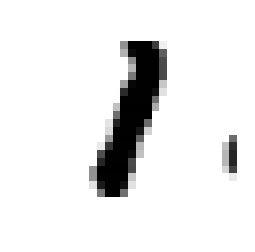

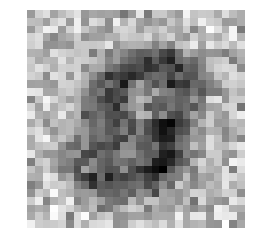

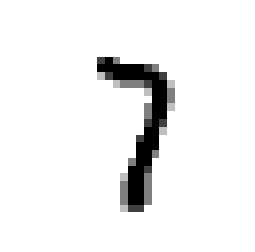

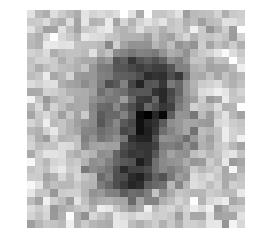

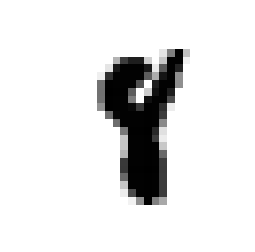

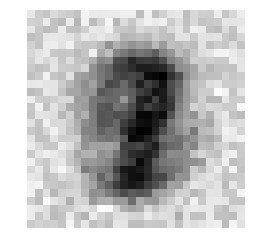

In [35]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

def show_image(image):
    plt.imshow(image, cmap = matplotlib.cm.binary,
        interpolation="nearest")
    plt.axis("off")
    plt.show()
    
visualisation_batch = mnist.train.images[:3]
o = sess.run([outputs], feed_dict={X: visualisation_batch})
o = np.array(o).reshape((-1, n_input_neurons))

image_shape = (input_spatial_size, input_spatial_size)
for input_data, output_data in zip(visualisation_batch, o):
    input_image = input_data.reshape(image_shape)
    show_image(input_image)
    output_image = output_data.reshape(image_shape)
    show_image(output_image)